In [1]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px


# Create the Snowflake connection hook once
snowhook = SnowflakeHook()

# Function for queries
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    df = snowhook.query_snowflake(query, method='pandas')

    # format Decimal -> float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)
    return df


2025-09-15 01:52:06,653 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-15 01:52:06,653 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

In [3]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises OLS R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


# ---------- Regression runner ----------

def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and return summary, prediction df, and coefficients."""
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit


    # Build summary with normalized coefficient names
    coef_dict = params.to_dict()
    if x in coef_dict:  # rename the main predictor to "x_col"
        coef_dict["x_col"] = coef_dict.pop(x)

    summary = pd.DataFrame({
        "kind": [kind],
        "formula": [fstr],
        "r2": [round(r2, 4)],
        **{coef: [val] for coef, val in coef_dict.items()}
    })


    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})

    return summary, pred_df


# ---------- Fit multiple shapes ----------

def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}
    summaries = []

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            results.append((kind, summ.loc[0, "formula"], summ.loc[0, "r2"]))
            fitted_dfs[kind] = pred_df
            summaries.append(summ)
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])
    coef_df = pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

    # Pick best model
    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df



In [4]:
def pred_formula(s, df):

    if df['kind'][0] == "power":
        
        intercept = df['Intercept'][0]
        _pow_x = df['_pow_x'][0]
        
        return (intercept + _pow_x*s**2)

    elif df['kind'][0] == "quadratic":

        intercep = df['Intercept'][0]
        _x2 = df['_x2'][0]
        x_col = df['x_col'][0]
        
        return (intercep + _x2*s**2 + x_col*s)
    
    elif df['kind'][0] == "sat_exp":
        scale = df['scale'][0]
        intercept = df['Intercept'][0]
        beta = df['_sat_x'][0]

        return intercept + beta * (1.0 - np.exp(-scale * s))

    elif df['kind'][0] == "linear":
        intercept = df['Intercept'][0]
        x_col = df['x_col'][0]

        return (intercept + x_col*s)
    
    
    else:
        print("not power or quadratic")
        return None

def inverse_model(y, df):
    kind = df['kind'][0]
    
    if kind == "power":
        a = df['_pow_x'][0]
        c = df['Intercept'][0]
        return np.sqrt((y - c) / a)   # only positive root (fits spend-style use case)
    
    elif kind == "quadratic":
        a = df['_x2'][0]
        b = df['x_col'][0]
        c = df['Intercept'][0] - y    # note: intercept - y

        disc = b**2 - 4*a*c
        if disc < 0:
            return np.nan   # no real roots
        roots = [(-b + np.sqrt(disc)) / (2*a),
                 (-b - np.sqrt(disc)) / (2*a)]
        return roots  # return both roots as a list
    
    elif kind == "sat_exp":
        scale = df['scale'][0]
        intercept = df['Intercept'][0]
        beta = df['_sat_x'][0]

        ratio = (y - intercept) / beta
        if ratio <= 0 or ratio >= 1:
            return np.nan  # outside valid range
        return -np.log(1 - ratio) / scale
    
    else:
        return None

## 1. Plot CPA Curve

In [5]:
# df_hist_cpa = load_query('./historical_cpa.sql')
df_hist_cpa = load_query('./sm81_cohort_hist_cpa.sql')

2025-09-15 01:52:13,518 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-15 01:52:13,519 - utils.snowflake_connection - INFO - Executing query (pandas)


In [6]:
df_hist_cpa.head()

df_hist_cpa['cpa'] = df_hist_cpa['paid_media_spend'] / (df_hist_cpa['paid_media_applicants'] * 0.7) # adjust for incrementality

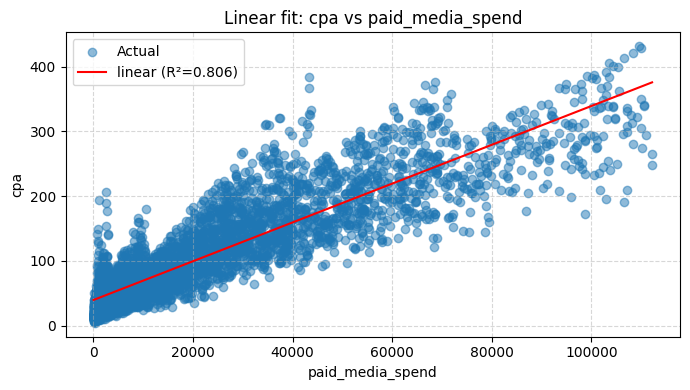


Best Model → linear  (R²=0.8063)


In [11]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["linear"]


df = df_hist_cpa.copy()


num_bins = 5  
percentile_cutoff = 0.9

df['bin'] = pd.qcut(df['paid_media_applicants'], q=num_bins, labels=False, duplicates='drop')
df['percentile'] = df.groupby('bin')['paid_media_spend'].transform(lambda x: x.rank(pct=True))
filtered_df = df[df['percentile'] <= percentile_cutoff]
# filtered_df = df.copy()
x_col = "paid_media_spend"
y_col = "cpa"


best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    filtered_df,
    x_col,
    y_col,
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model

spend_cpa_coef_df = coef_df
df_spend_cpa = best_fit_df.copy()


In [12]:
spend_cpa_coef_df

,kind,formula,r2,Intercept,x_col
0,linear,cpa = 0.0029954103·paid_media_spend + 39.59266...,0.8063,39.592667,0.002995


In [14]:

# spending = np.arange(1000000, 20000001, 1000000)
spending = np.arange(10000, 100001, 10000)

cpa = pred_formula(spending, spend_cpa_coef_df)

# build dataframe
df_prep = pd.DataFrame({
    "spending": spending,
    "cpa": cpa,
})

df_prep['applicants'] = df_prep['spending'] / df_prep['cpa']

df_prep

,spending,cpa,applicants
0,10000,69.546770,143.788129
1,20000,99.500874,201.003260
2,30000,129.454977,231.740800
3,40000,159.409080,250.926735
4,50000,189.363184,264.042878
5,60000,219.317287,273.576246
6,70000,249.271390,280.818428
7,80000,279.225494,286.506790
8,90000,309.179597,291.092947
9,100000,339.133700,294.868955


## 2. Calculate DAC Cost Curves - Global Level

### 2.1 DAC Cost Curve (Lifetime or 52w)

In [15]:
df_prep_lifetime = df_prep.copy()

# lifetime cost curve
df_prep_lifetime['new_dx'] = df_prep_lifetime['applicants'] * 0.28 # lifetime conversion rate
df_prep_lifetime['hours'] = df_prep_lifetime['new_dx'] * 170 # lifetime hours (52weeks)
df_prep_lifetime['wad'] = df_prep_lifetime['hours'] / 13 # online hours per dx

# calcualte marginal cost
def calc_marginal_cost(df):
    df['mcpd'] = df['spending'].diff() / df['new_dx'].diff()
    df['mcpwad'] = df['spending'].diff() / df['wad'].diff()
    df['mcpih'] = df['spending'].diff() / df['hours'].diff()
    return df

df_prep_lifetime = calc_marginal_cost(df_prep_lifetime)

df_prep_lifetime_output = df_prep_lifetime[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)

df_prep_lifetime_output['mcpd_vs_mcpwad'] = df_prep_lifetime_output['mcpd'] / df_prep_lifetime_output['mcpwad']
df_prep_lifetime_output['mcpd_vs_mcpih'] = df_prep_lifetime_output['mcpd'] / df_prep_lifetime_output['mcpih']

df_prep_lifetime_output

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,624.210504,47.733744,3.671826,13.076923,170.0
1,1161.910985,88.852016,6.834770,13.076923,170.0
2,1861.482766,142.348682,10.949899,13.076923,170.0
3,2722.925847,208.223741,16.017211,13.076923,170.0
4,3746.240228,286.477194,22.036707,13.076923,170.0
5,4931.425908,377.109040,29.008388,13.076923,170.0
6,6278.482889,480.119280,36.932252,13.076923,170.0
7,7787.411170,595.507913,45.808301,13.076923,170.0
8,9458.210751,723.274940,55.636534,13.076923,170.0


### 2.2 DAC Cost Curve (26w)

In [17]:
new_dx_landing_curve = load_query("sm81_cohort_landing_curve.sql")
new_dx_retention_curve = load_query("sm81_cohort_retention_curve.sql")

2025-09-15 01:56:42,498 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-09-15 01:57:00,521 - utils.snowflake_connection - INFO - Executing query (pandas)


In [18]:
def calc_scenario(spending, applicants, horizon = 26):

    def calc_weekly_converted_dx(new_dx_landing_curve, applicants):
        new_dx_landing_curve['new_dx'] = new_dx_landing_curve['new_dx_ratio'] * applicants
        return new_dx_landing_curve

    df_conv_dx = calc_weekly_converted_dx(new_dx_landing_curve, applicants)    

    hours_per_new_dx = 13.0 # online hours per dx

    df_retained_dx = df_conv_dx.merge(new_dx_retention_curve, how='cross')
    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    
    def keep_first_zero_rest(group):
        first_value = group.iloc[0]  # keep the first row’s original value
        group.iloc[1:] = 0           # set the rest to 0
        group.iloc[0] = first_value
        return group

    df_retained_dx['new_dx'] = df_retained_dx.groupby('horizon_conv')['new_dx'].transform(keep_first_zero_rest)

    df_retained_dx['horizon'] = df_retained_dx['horizon_conv'] + df_retained_dx['horizon_ret']
    df_retained_dx_26w = df_retained_dx[df_retained_dx['horizon'] <= horizon]
    df_retained_dx_26w = df_retained_dx_26w.groupby(['horizon']).agg({'wad': 'sum', 'new_dx': 'sum'}).reset_index(drop = False)
    df_retained_dx_26w['hours'] = df_retained_dx_26w['wad'] * hours_per_new_dx

    df_retained_dx_26w['spending'] = spending
    df_retained_dx_26w['applicants'] = applicants
    df_output = df_retained_dx_26w.groupby(['spending','applicants']).agg({ 'new_dx': 'sum', 'wad': 'sum','hours': 'sum'}).reset_index(drop = False)

    return df_output

In [22]:
df_prep_26w = pd.DataFrame()
# for spending in np.arange(1000000, 20000001, 1000000):
for spending in np.arange(10000, 100001, 10000):
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    df_output_tmp = calc_scenario(spending, applicants, horizon = 26)
    df_prep_26w = pd.concat([df_prep_26w, df_output_tmp])

df_prep_26w = calc_marginal_cost(df_prep_26w)
df_prep_26w_output = df_prep_26w[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)
df_prep_26w_output['mcpd_vs_mcpwad'] = df_prep_26w_output['mcpd'] / df_prep_26w_output['mcpwad']
df_prep_26w_output['mcpd_vs_mcpih'] = df_prep_26w_output['mcpd'] / df_prep_26w_output['mcpih']
df_prep_26w_output

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,603.237238,81.295910,6.253532,7.420266,96.463452
1,1122.871161,151.324930,11.640379,7.420266,96.463452
2,1798.937562,242.435739,18.648903,7.420266,96.463452
3,2631.436440,354.628339,27.279103,7.420266,96.463452
4,3620.367797,487.902728,37.530979,7.420266,96.463452
5,4765.731632,642.258907,49.404531,7.420266,96.463452
6,6067.527944,817.696875,62.899760,7.420266,96.463452
7,7525.756735,1014.216634,78.016664,7.420266,96.463452
8,9140.418003,1231.818182,94.755245,7.420266,96.463452


In [23]:
df_prep_52w = pd.DataFrame()
# for spending in np.arange(1000000, 20000001, 1000000):
for spending in np.arange(10000, 100001, 10000):
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    df_output_tmp = calc_scenario(spending, applicants, horizon = 52)
    df_prep_52w = pd.concat([df_prep_52w, df_output_tmp])

df_prep_52w = calc_marginal_cost(df_prep_52w)
df_prep_52w_output = df_prep_52w[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)
df_prep_52w_output['mcpd_vs_mcpwad'] = df_prep_52w_output['mcpd'] / df_prep_52w_output['mcpwad']
df_prep_52w_output['mcpd_vs_mcpih'] = df_prep_52w_output['mcpd'] / df_prep_52w_output['mcpih']
df_prep_52w_output


,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,527.133265,49.603348,3.815642,10.62697,138.150604
1,981.210549,92.332113,7.102470,10.62697,138.150604
2,1571.984903,147.924100,11.378777,10.62697,138.150604
3,2299.456327,216.379310,16.644562,10.62697,138.150604
4,3163.624821,297.697741,22.899826,10.62697,138.150604
5,4164.490385,391.879395,30.144569,10.62697,138.150604
6,5302.053018,498.924271,38.378790,10.62697,138.150604
7,6576.312722,618.832370,47.602490,10.62697,138.150604
8,7987.269495,751.603690,57.815668,10.62697,138.150604


### 2.3 Global Spending <> mCPD Scenario

df_prep_26w_output: based on new dx conversion and landing curve, actual mCPD <> mCPWAD <> mCPIH

df_prep_lifetime_output: based on lifetime new dx conversion and lifetime hours, actual mCPD <> mCPWAD <> mCPIH

In [24]:
df_sim_output = load_query("all_sms_daco_output.sql")

2025-09-15 02:02:05,706 - utils.snowflake_connection - INFO - Executing query (pandas)


In [25]:
df_sm0 = df_sim_output[df_sim_output['submarket_id'] == 81]

df_sm0_spend_mcpd = df_sm0[['mcpd_scenario', 'spending']]

df_sm0_spend_mcpd

,mcpd_scenario,spending
311,1000,6000.000000
312,2000,21107.519790
313,3000,41105.725790
314,4000,60105.725790
315,5000,81515.973790
316,6000,94812.045388
317,7000,103670.865888
318,8000,110024.907949
319,9000,115551.928980
320,10000,121745.703780


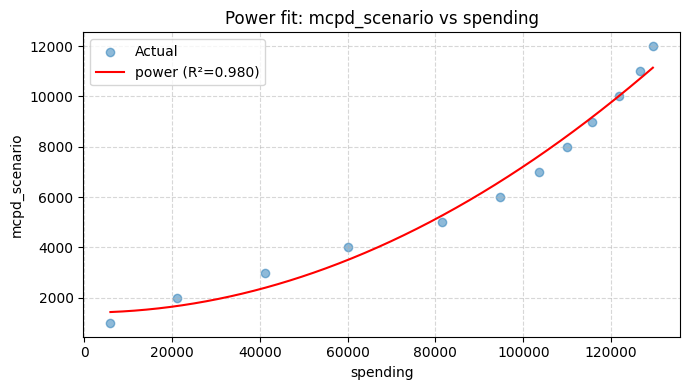


Best Model → power  (R²=0.9802)


In [26]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

df_plot = df_sm0_spend_mcpd.copy()
x_col = "spending"
y_col = "mcpd_scenario"


best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
   df_plot,
    x_col,
    y_col,
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

In [27]:
spending_mcpd_coef_df = coef_df
df_fit_output = best_fit_df.copy()

df_fit_output = df_fit_output[['spending', 'mcpd_scenario']]
df_fit_output.rename(columns={'mcpd_scenario': 'pred_mcpd'}, inplace=True)

In [28]:
mcpd_vs_mcpwad_26w = df_prep_26w_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_26w = df_prep_26w_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_52w = df_prep_52w_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_52w = df_prep_52w_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_lifetime = df_prep_lifetime_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_lifetime = df_prep_lifetime_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_26w, mcpd_vs_mcpih_26w, mcpd_vs_mcpwad_52w, mcpd_vs_mcpih_52w, mcpd_vs_mcpwad_lifetime, mcpd_vs_mcpih_lifetime


(7.4202655365600005,
 96.46345197527998,
 10.626969507729974,
 138.15060360048963,
 13.076923076923075,
 169.99999999999997)

In [29]:
df_fit_output['pred_mcpwad_26w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_26w
df_fit_output['pred_mcpih_26w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_26w

df_fit_output['pred_mcpwad_52w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_52w
df_fit_output['pred_mcpih_52w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_52w

df_fit_output['pred_mcpwad_lifetime'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_lifetime
df_fit_output['pred_mcpih_lifetime'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_lifetime

df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
0,6000.000000,1431.096523,192.863249,14.835635,134.666475,10.358960,109.436793,8.418215
1,6247.517928,1432.855888,193.100352,14.853873,134.832032,10.371695,109.571333,8.428564
2,6495.035857,1434.686365,193.347038,14.872849,135.004280,10.384945,109.711310,8.439332
3,6742.553785,1436.587954,193.603308,14.892562,135.183220,10.398709,109.856726,8.450517
4,6990.071714,1438.560655,193.869161,14.913012,135.368851,10.412989,110.007580,8.462122
...,...,...,...,...,...,...,...,...
495,128521.374558,10996.521244,1481.957915,113.996763,1034.774894,79.598069,840.910448,64.685419
496,128768.892486,11033.481173,1486.938859,114.379912,1038.252831,79.865602,843.736796,64.902830
497,129016.410415,11070.512213,1491.929387,114.763799,1041.737459,80.133651,846.568581,65.120660
498,129263.928343,11107.614366,1496.929498,115.148423,1045.228779,80.402214,849.405804,65.338908


### Plot Global Curve Graph

In [30]:
df_fit_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   spending              500 non-null    float64
 1   pred_mcpd             500 non-null    float64
 2   pred_mcpwad_26w       500 non-null    float64
 3   pred_mcpih_26w        500 non-null    float64
 4   pred_mcpwad_52w       500 non-null    float64
 5   pred_mcpih_52w        500 non-null    float64
 6   pred_mcpwad_lifetime  500 non-null    float64
 7   pred_mcpih_lifetime   500 non-null    float64
dtypes: float64(8)
memory usage: 31.4 KB


In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
import numpy as np

def plot_mcpwad_curve(df, spending_range=(None, None), mcpd_range=(1000, None), mcpd_step=1000, static_wad=280):
    """
    Plot spending vs. mCPWAD (26wks + lifetime) with markers at every `mcpd_step`,
    plus a horizontal line for static mCPWAD.

    Parameters
    ----------
    df : DataFrame
        Must contain ['spending', 'pred_mcpwad_26w', 'pred_mcpwad_lifetime', 'pred_mcpd']
    spending_range : tuple
        (xmin, xmax) for x-axis in dollars. Use None for auto.
    mcpd_range : tuple
        (min_mcpd, max_mcpd) for annotation ticks in mCPD units. Use None for auto.
    mcpd_step : int
        Step size for mCPD annotations (default=1000).
    static_wad : float
        Reference horizontal line value for mCPWAD.
    """
    # style
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,
    })

    fig, ax = plt.subplots(figsize=(7,4))

    # 1) main lines
    line1, = ax.plot(
        df["spending"], df["pred_mcpwad_26w"],
        label="DAC CPIWAD (26wks)", color="#038c0a", linewidth=1.5, zorder=2
    )
    # line2, = ax.plot(
    #     df["spending"], df["pred_mcpwad_lifetime"],
    #     label="DAC CPIWAD (lifetime)", color="#0778b5", linewidth=1.5, zorder=2
    # )
    line4, = ax.plot(
        df["spending"], df["pred_mcpwad_52w"],
        label="DAC CPIWAD (52wks)", color="#0778b5", linewidth=1.5, zorder=2
    )

    # 2) static reference line
    line3 = ax.axhline(
        y=static_wad, color="red", linestyle=":", linewidth=1.5,
        label=f"BP CPIWAD = {static_wad}"
    )

    # 3) marks every `mcpd_step` in mCPD range
    mcpd_min = mcpd_range[0] if mcpd_range[0] is not None else df["pred_mcpd"].min()
    mcpd_max = mcpd_range[1] if mcpd_range[1] is not None else df["pred_mcpd"].max()
    mcpd_marks = np.arange(mcpd_min, mcpd_max, mcpd_step)

    spending_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["spending"])
    mcpwad26_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_26w"])
    mcpwad52_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_52w"])
    # mcpwadLT_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_lifetime"])

    ax.scatter(spending_marks, mcpwad26_marks, marker='o', s=10, color="#038c0a", zorder=3)
    ax.scatter(spending_marks, mcpwad52_marks, marker='o', s=10, color="#0778b5", zorder=3)
    # ax.scatter(spending_marks, mcpwadLT_marks, marker='o', s=10, color="#0778b5", zorder=3) # s, as square

    # 4) annotate with mCPD labels
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    for s, y, mcpd in zip(spending_marks, mcpwad26_marks, mcpd_marks):
        ax.annotate(f"{int(mcpd/1000)}k", (s, y),
                    xytext=(0,6), textcoords="offset points",
                    ha="center", fontsize=7, color="#038c0a", path_effects=halo)

    for s, y, mcpd in zip(spending_marks, mcpwad52_marks, mcpd_marks):
        ax.annotate(f"{int(mcpd/1000)}k", (s, y),
                    xytext=(0,6), textcoords="offset points",
                    ha="center", fontsize=7, color="#0778b5", path_effects=halo)

    # for s, y, mcpd in zip(spending_marks, mcpwadLT_marks, mcpd_marks):
    #     ax.annotate(f"{int(mcpd/1000)}k", (s, y),
    #                 xytext=(0,-9), textcoords="offset points",
    #                 ha="center", fontsize=7, color="#0778b5", path_effects=halo)

    # 5) formatting
    xmin = spending_range[0] if spending_range[0] is not None else df["spending"].min()
    xmax = spending_range[1] if spending_range[1] is not None else df["spending"].max()
    ax.set_xlim(xmin, xmax)

    ax.set_xlabel("Paid Media Spend")
    ax.set_ylabel("CPIWAD")
    ax.set_title("SM81-Pittsburgh Cost Curve: Spending vs CPIWAD", fontweight="bold", fontsize=10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.legend(handles=[line1, line4, line3], fontsize=8, framealpha=0.9, loc="upper left")

    fig.tight_layout()
    plt.show()


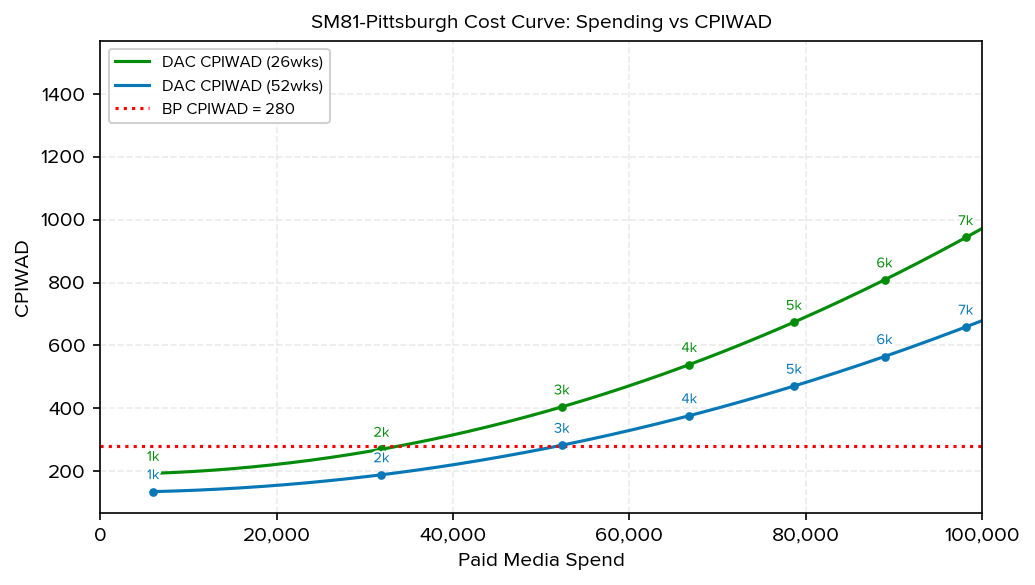

In [36]:
# zoom in: spending 1M–8M, mCPD labels from 2000 to 8000
plot_mcpwad_curve(df_fit_output, spending_range=(0, 100_000), mcpd_range=(1000, 10000), mcpd_step=1000 , static_wad=280)




In [37]:
df_fit_output[(df_fit_output['pred_mcpd'] <= 3100) & (df_fit_output['pred_mcpd'] >= 2900)]

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
181,50800.745040,2907.960067,391.894340,30.145718,273.639636,21.049203,222.373417,17.105647
182,51048.262969,2922.590749,393.866060,30.297389,275.016386,21.155107,223.492234,17.191710
183,51295.780897,2937.292543,395.847363,30.449797,276.399828,21.261525,224.616489,17.278191
184,51543.298826,2952.065449,397.838249,30.602942,277.789961,21.368459,225.746181,17.365091
185,51790.816754,2966.909468,399.838719,30.756825,279.186787,21.475907,226.881312,17.452409
186,52038.334682,2981.824599,401.848773,30.911444,280.590303,21.583869,228.021881,17.540145
187,52285.852611,2996.810842,403.868410,31.066801,282.000512,21.692347,229.167888,17.628299
188,52533.370539,3011.868197,405.897630,31.222895,283.417412,21.801339,230.319333,17.716872
189,52780.888468,3026.996665,407.936434,31.379726,284.841004,21.910846,231.476216,17.805863
190,53028.406396,3042.196245,409.984822,31.537294,286.271288,22.020868,232.638536,17.895272


### Calculate avg Weekly Applicants and WAD given certain Spend

In [38]:
df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
0,6000.000000,1431.096523,192.863249,14.835635,134.666475,10.358960,109.436793,8.418215
1,6247.517928,1432.855888,193.100352,14.853873,134.832032,10.371695,109.571333,8.428564
2,6495.035857,1434.686365,193.347038,14.872849,135.004280,10.384945,109.711310,8.439332
3,6742.553785,1436.587954,193.603308,14.892562,135.183220,10.398709,109.856726,8.450517
4,6990.071714,1438.560655,193.869161,14.913012,135.368851,10.412989,110.007580,8.462122
...,...,...,...,...,...,...,...,...
495,128521.374558,10996.521244,1481.957915,113.996763,1034.774894,79.598069,840.910448,64.685419
496,128768.892486,11033.481173,1486.938859,114.379912,1038.252831,79.865602,843.736796,64.902830
497,129016.410415,11070.512213,1491.929387,114.763799,1041.737459,80.133651,846.568581,65.120660
498,129263.928343,11107.614366,1496.929498,115.148423,1045.228779,80.402214,849.405804,65.338908


In [39]:
def keep_first_zero_rest(group):
    first_value = group.iloc[0]  # keep the first row’s original value
    group.iloc[1:] = 0           # set the rest to 0
    group.iloc[0] = first_value
    return group


def calc_scenario_weekly(spending, applicants):

    def calc_weekly_converted_dx(new_dx_landing_curve, applicants):
        new_dx_landing_curve['new_dx'] = new_dx_landing_curve['new_dx_ratio'] * applicants
        return new_dx_landing_curve

    df_conv_dx = calc_weekly_converted_dx(new_dx_landing_curve, applicants)    

    hours_per_new_dx = 13.0 # online hours per dx

    df_retained_dx = df_conv_dx.merge(new_dx_retention_curve, how='cross')
    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    
    df_retained_dx['new_dx'] = df_retained_dx.groupby('horizon_conv')['new_dx'].transform(keep_first_zero_rest)
    df_retained_dx['hours'] = df_retained_dx['wad'] * hours_per_new_dx

    df_retained_dx['spending'] = spending
    df_retained_dx['applicants'] = applicants
    
    df_output = df_retained_dx[['spending','applicants','horizon_conv','new_dx','horizon_ret','wad','hours']]

    return df_output

In [49]:
spend_list = [75502, 83342, 86827, 52038, 57442, 59844]

results = []
for spending in spend_list:
    cpa = pred_formula(spending, spend_cpa_coef_df)  # your real coef_df goes here
    applicants = spending / cpa
    applicants_adj = applicants / 0.7
    results.append([spending, cpa, applicants, applicants_adj])

# Save results in DataFrame
df_apps_adj = pd.DataFrame(results, columns=["spending", "cpa", "applicants", "applicants_adj"])

df_apps_adj['cpa_adj'] = df_apps_adj['spending'] / df_apps_adj['applicants_adj']
df_apps_adj


,spending,cpa,applicants,applicants_adj,cpa_adj
0,75502,265.752138,284.106839,405.866913,186.026497
1,83342,289.236155,288.145166,411.635952,202.465309
2,86827,299.675160,289.737060,413.910086,209.772612
3,52038,195.467830,266.222836,380.318337,136.827481
4,57442,211.655027,271.394451,387.706359,148.158519
5,59844,218.850003,273.447563,390.639376,153.195002


In [44]:
df_weekly_output = pd.DataFrame()

for spending in spend_list:

    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):

        horizon = spending_horizon 
        df_weekly_output_tmp = calc_scenario(spending, applicants, horizon)
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = df_weekly_output_tmp.groupby('horizon_spend')['spending'].transform(keep_first_zero_rest)
        df_weekly_output_tmp['applicants'] = df_weekly_output_tmp.groupby('horizon_spend')['applicants'].transform(keep_first_zero_rest)
    
        df_weekly_output = pd.concat([df_weekly_output, df_weekly_output_tmp])

df_weekly_output

,spending,applicants,new_dx,wad,hours,horizon_spend
0,75502,284.106839,32.879116,32.879116,427.428512,0
0,75502,284.106839,49.473939,71.404840,928.262921,1
0,75502,284.106839,56.150592,106.548433,1385.129632,2
0,75502,284.106839,60.954412,139.747704,1816.720153,3
0,75502,284.106839,65.127800,172.005021,2236.065271,4
...,...,...,...,...,...,...
0,59844,273.447563,64.894029,263.181989,3421.365853,8
0,59844,273.447563,64.894029,283.061728,3679.802464,9
0,59844,273.447563,64.894029,301.713703,3922.278137,10
0,59844,273.447563,67.303375,321.717504,4182.327549,11


In [45]:
spend_list = [75502, 83342, 86827, 52038, 57442, 59844]

df_list = []

for spending in spend_list:
    
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):
        horizon = spending_horizon

        # calculate scenario (your custom function)
        df_weekly_output_tmp = calc_scenario(spending, applicants_adj, horizon)

        # add metadata columns
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['spending']
            .transform(keep_first_zero_rest)
        )
        df_weekly_output_tmp['applicants'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['applicants']
            .transform(keep_first_zero_rest)
        )

        df_list.append(df_weekly_output_tmp)

# Concatenate once at the end
df_weekly_output = pd.concat(df_list, ignore_index=True)

# Example metric
mean_wad = df_weekly_output['wad'].mean()

df_weekly_output

,spending,applicants,new_dx,wad,hours,horizon_spend
0,75502,405.866913,46.970166,46.970166,610.612160,0
1,75502,405.866913,70.677055,102.006914,1326.089887,1
2,75502,405.866913,80.215131,152.212047,1978.756617,2
3,75502,405.866913,87.077732,199.639577,2595.314504,3
4,75502,405.866913,93.039714,245.721458,3194.378959,4
...,...,...,...,...,...,...
73,59844,390.639376,92.705755,375.974270,4887.665504,8
74,59844,390.639376,92.705755,404.373897,5256.860663,9
75,59844,390.639376,92.705755,431.019576,5603.254482,10
76,59844,390.639376,96.147679,459.596434,5974.753642,11


In [46]:
df_weekly_output_grouped = df_weekly_output.groupby(['spending', 'applicants']).agg({
    'new_dx': 'mean'
    , 'wad': 'mean'
    , 'hours': 'mean'}).reset_index(drop = False)

df_weekly_output_grouped

,spending,applicants,new_dx,wad,hours
0,52038,380.318337,83.356842,285.482439,3711.271702
1,57442,387.706359,84.976123,291.028189,3783.366456
2,59844,390.639376,85.618971,293.229831,3811.987802
3,75502,405.866913,88.956490,304.660241,3960.583134
4,83342,411.635952,90.220927,308.990716,4016.879313
5,86827,413.910086,90.719364,310.697775,4039.071069


In [52]:
df_apps_adj.merge(df_weekly_output_grouped[['spending', 'new_dx','wad','hours']], on=['spending'], how='left')

,spending,cpa,applicants,applicants_adj,cpa_adj,new_dx,wad,hours
0,75502,265.752138,284.106839,405.866913,186.026497,88.956490,304.660241,3960.583134
1,83342,289.236155,288.145166,411.635952,202.465309,90.220927,308.990716,4016.879313
2,86827,299.675160,289.737060,413.910086,209.772612,90.719364,310.697775,4039.071069
3,52038,195.467830,266.222836,380.318337,136.827481,83.356842,285.482439,3711.271702
4,57442,211.655027,271.394451,387.706359,148.158519,84.976123,291.028189,3783.366456
5,59844,218.850003,273.447563,390.639376,153.195002,85.618971,293.229831,3811.987802
